In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.table import Table
import datetime
from astropy.time import Time
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
import pPXF_wrapper

from matplotlib.gridspec import GridSpec
importlib.reload(pPXF_wrapper)


<module 'pPXF_wrapper' from '/Users/katja.fahrion/Documents/Scripts/MyPackages/pPXF_wrapper/pPXF_wrapper/__init__.py'>

First fit done. Starting the MC fits on 4 cores... this can take a while
Saving ./Spec_MC_2_runs_kin_only.dat


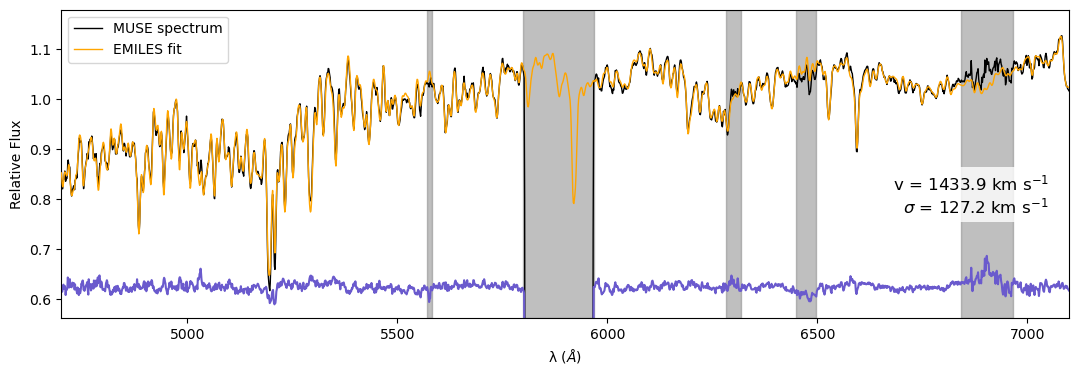

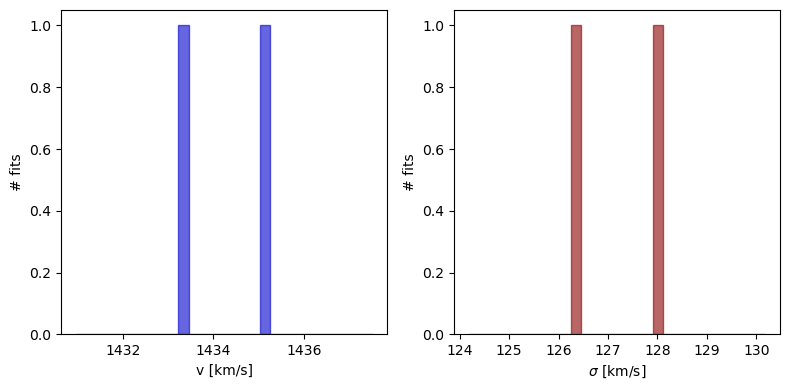

In [2]:
%matplotlib inline
spec_MUSE = ascii.read('../pPXF_wrapper/pPXF_wrapper/spectra/NGC1796_MUSE_spec.dat')
spec_MUSE = ascii.read('../pPXF_wrapper/pPXF_wrapper/spectra/FCC47_MUSE_spec.dat')

mask_file = '/Users/katja.fahrion/Library/CloudStorage/OneDrive-ESA/ForIvan/ETGs/line_masks/line_mask_FCC47.dat'
#ppw_emiles2 = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_MUSE['wave'], spec_MUSE['NSC_spec'], mask_file=mask_file, lam_range=[4700, 7100], instrument='MUSE',
 #                                      ssp_models = 'EMILES', kin_only=True, gas_fit=True, degree=12, moments=4, save_plots=True)

ppw_e = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper_MC(spec_MUSE['wave'], spec_MUSE['NSC_spec'], mask_file=mask_file, lam_range=[4700, 7100], 
                                          instrument='MUSE', ssp_models = 'EMILES', kin_only=True, gas_fit=False, degree=12, 
                                          n=2)

In [3]:
print(ppw_e.regul)

AttributeError: 'NoneType' object has no attribute 'regul'

In [3]:
def plot_kin_fit(ppw, text_loc=[0.98, 0.5], ax=None, xlabel=None, ylabel=None,
                           title=None, legend_loc='upper left', zoom_to_stars = False):
    if ax is None:
        fig, ax = plt.subplots(figsize=[13, 4])
        save_plot = True 
    else:
        save_plot = False # don't save if ax was given
    pp = ppw.pp
    fit_label = ppw.ssp_models
    spec_label = '{} spectrum'.format(ppw.instrument)
    ax.plot(pp.lam, pp.galaxy, c='k', label=spec_label, lw=1)
    ax.plot(pp.lam, pp.bestfit, c='orange', label='{0} fit'.format(fit_label), zorder=300, lw=1)

    res = pp.galaxy - pp.bestfit
    mn = np.min(pp.bestfit[pp.goodpixels])
    mn -= np.percentile(np.abs(res[pp.goodpixels]), 99)
    mx = np.max(pp.bestfit[pp.goodpixels])
    
    if (ppw.gas_fit) and (zoom_to_stars):
        print('ho')
        mn = np.min(pp.bestfit[pp.goodpixels]- pp.gas_bestfit[pp.goodpixels])
        mn -= np.percentile(np.abs(res[pp.goodpixels]), 99)
        mx = np.max(pp.bestfit[pp.goodpixels]- pp.gas_bestfit[pp.goodpixels])
    
    res += mn   # Offset residuals to avoid overlap
    mn1 = np.min(res[pp.goodpixels])
    
    if ppw.gas_fit:    
        ax.plot(pp.lam, pp.gas_bestfit + mn, c='darkred', zorder=2, lw=1)
        
    if ylabel is None:
        ax.set_ylabel("Relative Flux")
    else:
        ax.set_ylabel(ylabel)
    if xlabel is None:
        if ppw.templates.wavelength_unit == u.AA:
            ax.set_xlabel(r'$\rm{\lambda}$ ($\AA$)')
        else:
            ax.set_xlabel(r'$\rm{\lambda}$ ($\mu$m)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylim([mn1, mx] + np.array([-0.05, 0.1])*(mx - mn1))

    w = np.flatnonzero(np.diff(pp.goodpixels) > 1)
    if w.size > 0:
        for wj in w:
            j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
            xi = pp.lam[j]
            ax.axvspan(xi[0], xi[-1], color='grey', alpha=0.5)
        w = np.hstack([0, w, w + 1, -1])  # Add first and last point
    else:
        w = [0, -1]
    ax.plot(pp.lam, res, c='slateblue')
    if not title is None:
        ax.set_title(title)
        
    if not ppw.gas_fit:
        string = 'v = {0}'.format(np.round(
                    pp.sol[0], 1)) + r' km s$^{-1}$' + '\n' +r'$\sigma$ = ' + '{0}'.format(np.round(pp.sol[1], 1)) + r' km s$^{-1}$'
    else:
        string = r'$v_{\rm{stars}}$' + ' = {0}'.format(np.round(
            pp.sol[0][0], 1)) + r' km s$^{-1}$' + '\n' + \
            r'$v_{\rm{gas}}$' + ' = {0}'.format(np.round(
                pp.sol[1][0], 1)) + r' km s$^{-1}$'
    t = ax.text(text_loc[0], text_loc[1], string, color='black',     horizontalalignment='right',
                verticalalignment='center', fontsize=12,
                transform=ax.transAxes, backgroundcolor='w', zorder=350)
    t.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor=None, linewidth=0))
    ax.legend(loc=legend_loc).set_zorder(1002)
    ax.set_xlim(pp.lam[0], pp.lam[-1])
    if (ppw.save_plots) and save_plot:
        plt.savefig(ppw.plot_out + ppw.plot_kin_title)
        

def plot_age_metal_grid(ppw, ax=None,  colorbar_position='top',
                        outdir = None, grid_plot_title='age_metal_grid'):
    if ax is None:
        fig, ax = plt.subplots(figsize=[6.5, 4])
        save_plot = ppw.save_plots
    else:
        save_plot = False
    pp = ppw.pp
    templates = ppw.templates
    
    weights = pp.weights[~pp.gas_component].reshape(
    templates.n_ages, templates.n_metal)/pp.weights[~pp.gas_component].sum()
    mean_age, mean_metal = templates.mean_age_metal(weights, quiet=True)
    
    xgrid = templates.age_grid
    ygrid = templates.metal_grid
    mean_age = np.sum(weights*xgrid)/np.sum(weights)
    mean_metal = np.sum(weights*ygrid)/np.sum(weights)

    std_age = np.sqrt(np.sum(weights)/(np.sum(weights)**2 - np.sum(weights**2))
                        * np.sum(weights * (xgrid - mean_age)**2))
    std_metal = np.sqrt(np.sum(weights)/(np.sum(weights)**2 - np.sum(weights**2))
                            * np.sum(weights * (ygrid - mean_metal)**2))
        
    x = xgrid[:, 0]
    y = ygrid[0, :]
    xb = (x[1:] + x[:-1])/2  # grid borders
    yb = (y[1:] + y[:-1])/2
    xb = np.hstack([1.5*x[0] - x[1]/2, xb, 1.5*x[-1] - x[-2]/2])
    yb = np.hstack([1.5*y[0] - y[1]/2, yb, 1.5*y[-1] - y[-2]/2])

    # pcolormesh() is used below to allow for irregular spacing in the
    # sampling of the stellar population parameters (e.g. metallicity)
    xlabel = "Age (Gyr)"
    ylabel = "[M/H]"
    pc = ax.pcolormesh(xb, yb, weights.T, cmap='bone_r', edgecolors='lightgray', lw=0.01)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(min(yb), max(yb))
    ax.set_xlim(min(xb), max(xb))
    t = ax.text(0.03, 0.08, 'Mean age: {0} Gyr'.format(np.round(mean_age, 1)) + '\n' + r'Mean [M/H]: {0}'.format(np.round(mean_metal, 2)), color='black',     horizontalalignment='left',
                verticalalignment='center', fontsize=12,
                transform=ax.transAxes, backgroundcolor='w')

    t.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor=None, linewidth=0))
    ax.scatter(mean_age, mean_metal, color='k', marker='x')
    ax.errorbar(mean_age, mean_metal, xerr=std_age, yerr=std_metal, color='k', capsize=5)
    divider = make_axes_locatable(ax)
    if colorbar_position == 'top':
        cax = divider.append_axes("top", "1.5%", pad="1.5%")
        cbar = plt.colorbar(pc, cax=cax, orientation='horizontal')
        cax.xaxis.set_ticks_position('top')
        cax.xaxis.set_label_position('top')
    else:
        cax = divider.append_axes("right", "1.5%", pad="1.5%")
        cbar = plt.colorbar(pc, cax=cax)
    cbar.set_label(r'{0} weights'.format(ppw.ssp_models), fontsize=14)
    if save_plot:
        if outdir is None:
            outdir = ppw.plot_out
            print('Saving to {0}'.format(outdir))
        plt.saveplot(outdir + grid_plot_title)


def plot_pop_fit(ppw, ax0=None, ax1=None, xlabel=None, ylabel=None,
                           title=None, legend_loc='upper left', zoom_to_stars = False, outdir=None, save_plots=False):
    if ax0 is None:
        fig = plt.figure(figsize=[13, 3.5], constrained_layout=True)
        gs = GridSpec(1, 5, figure=fig)
        ax0 = fig.add_subplot(gs[:4])
        ax1 = fig.add_subplot(gs[4::])
    plot_kin_fit(ppw, ax=ax0, xlabel=xlabel, ylabel=ylabel, title=title, legend_loc=legend_loc, zoom_to_stars=zoom_to_stars)
    plot_age_metal_grid(ppw, ax=ax1, colorbar_position='top')
    
    for ax in [ax0, ax1]:
        ax.tick_params(labelsize=12)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)
    
    if (ppw.save_plots) or (save_plots):
        if outdir is None:
            outdir = ppw.plot_out
            print('Saveing to {0}'.format(outdir))
        plt.savefig(outdir + ppw.plot_pop_title, bbox_inches='tight')
        

In [4]:
def plot_spectrum_with_fit(ppw, spec_label = 'MUSE spectrum', fit_label='E-MILES', 
                           legend_loc='upper left', text_loc=[0.98, 0.4], ax=None, xlabel=None, ylabel=None,
                           title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=[13, 4])
    pp = ppw.pp
    ax.plot(pp.lam, pp.galaxy, c='k', label=spec_label)
    ax.plot(pp.lam, pp.bestfit, c='orange', label='{0} fit'.format(fit_label))
    res = pp.galaxy - pp.bestfit
    mn = np.min(pp.bestfit[pp.goodpixels])
    mn -= np.percentile(np.abs(res[pp.goodpixels]), 99)
    mx = np.max(pp.bestfit[pp.goodpixels])
    res += mn   # Offset residuals to avoid overlap
    mn1 = np.min(res[pp.goodpixels])
    if ylabel is None:
        ax.set_ylabel("Relative Flux")
    else:
        ax.set_ylabel(ylabel)
    if xlabel is None:
        ax.set_xlabel(r'$\rm{\lambda}$ ($\AA$)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylim([mn1, mx] + np.array([-0.05, 0.1])*(mx - mn1))

    w = np.flatnonzero(np.diff(pp.goodpixels) > 1)
    if w.size > 0:
        for wj in w:
            j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
            xi = pp.lam[j]
            ax.axvspan(xi[0], xi[-1], color='grey', alpha=0.5)
        w = np.hstack([0, w, w + 1, -1])  # Add first and last point
    else:
        w = [0, -1]
    ax.plot(pp.lam, res, c='slateblue')
    if not title is None:
        ax.set_title(title)
        
    string = 'v = {0}'.format(np.round(
                pp.sol[0], 1)) + r' km s$^{-1}$' + '\n' +r'$\sigma$ = ' + '{0}'.format(np.round(pp.sol[1], 1)) + r' km s$^{-1}$'
            
    t = ax.text(text_loc[0], text_loc[1], string, color='black',     horizontalalignment='right',
                verticalalignment='center', fontsize=12,
                transform=ax.transAxes, backgroundcolor='w', zorder=350)
    t.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor=None, linewidth=0))
    ax.legend(loc=legend_loc)
    ax.set_xlim(pp.lam[0], pp.lam[-1])

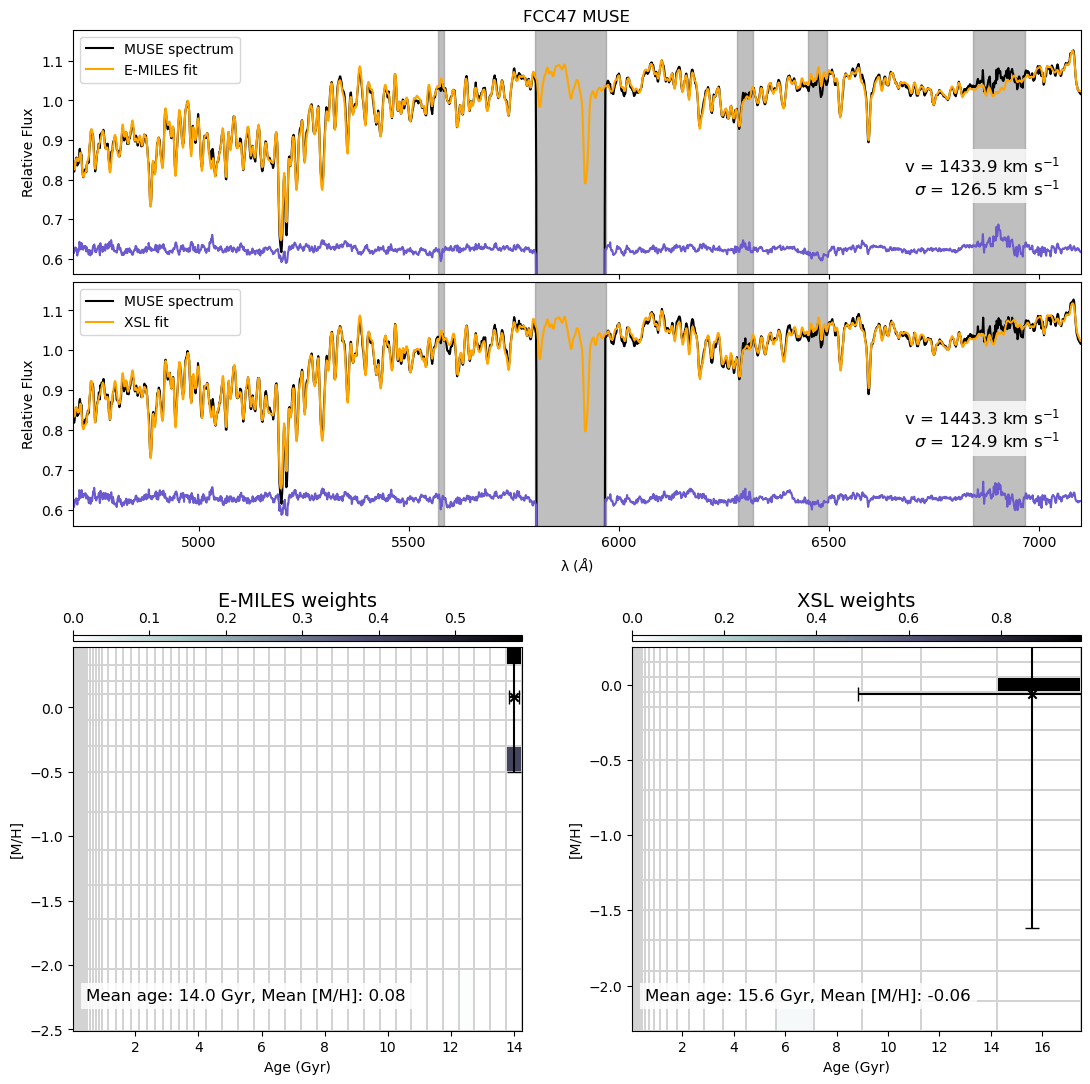

In [6]:
#FCC47 MUSE plot
fig = plt.figure(figsize=[13, 13])
gs = GridSpec(20, 20, figure=fig)
ax0 = fig.add_subplot(gs[0:5, :])
ax1 = fig.add_subplot(gs[5:10, :])
ax2 = fig.add_subplot(gs[12::, 0:9])
ax3 = fig.add_subplot(gs[12::, 11::])


plot_spectrum_with_fit(ppw_emiles, spec_label='MUSE spectrum', fit_label='E-MILES', title='FCC47 MUSE', ax=ax0, xlabel='')
plot_spectrum_with_fit(ppw_xsl, spec_label='MUSE spectrum', fit_label='XSL', title=None, ax=ax1)
plot_age_metal_grid(ppw_emiles, ax=ax2, label='E-MILES')
plot_age_metal_grid(ppw_xsl, ax=ax3, label='XSL')
plt.savefig("FCC47_MUSE_fit.pdf")


117.78728807613152

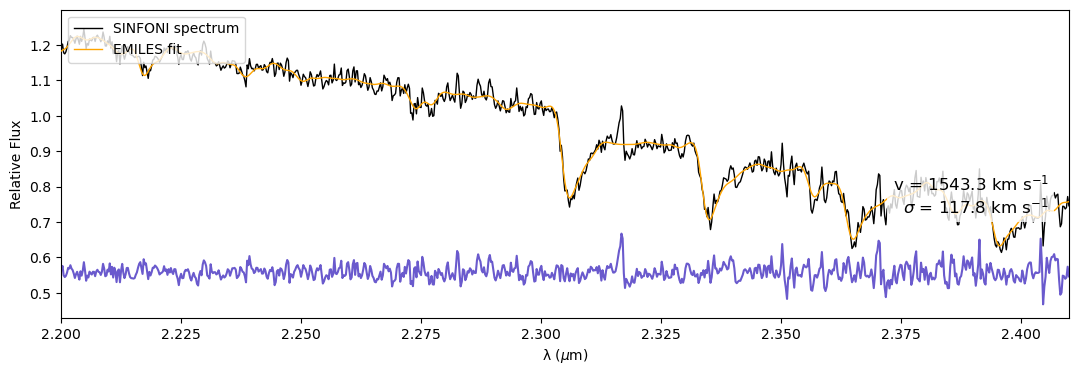

In [3]:
spec_sin = ascii.read('../pPXF_wrapper/pPXF_wrapper/spectra/FCC47_sinfoni_spec.dat')

ppw_sin_e = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, lam_range=[2.2, 2.41], 
                                                                   instrument='SINFONI', ssp_models = 'EMILES', kin_only=True, 
                                                                   plot=True 
                                                                   )


ppw_sin_xsl = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, 
                                                                       lam_range=[2.2, 2.41], instrument='SINFONI', ssp_models = 'XSL',
                                                                       kin_only=True,  plot=False)

ppw_sin_sin = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, 
                                                                       lam_range=[2.2, 2.41], instrument='SINFONI', ssp_models = 'sinfoni_k',
                                                                       kin_only=True,  plot=False)




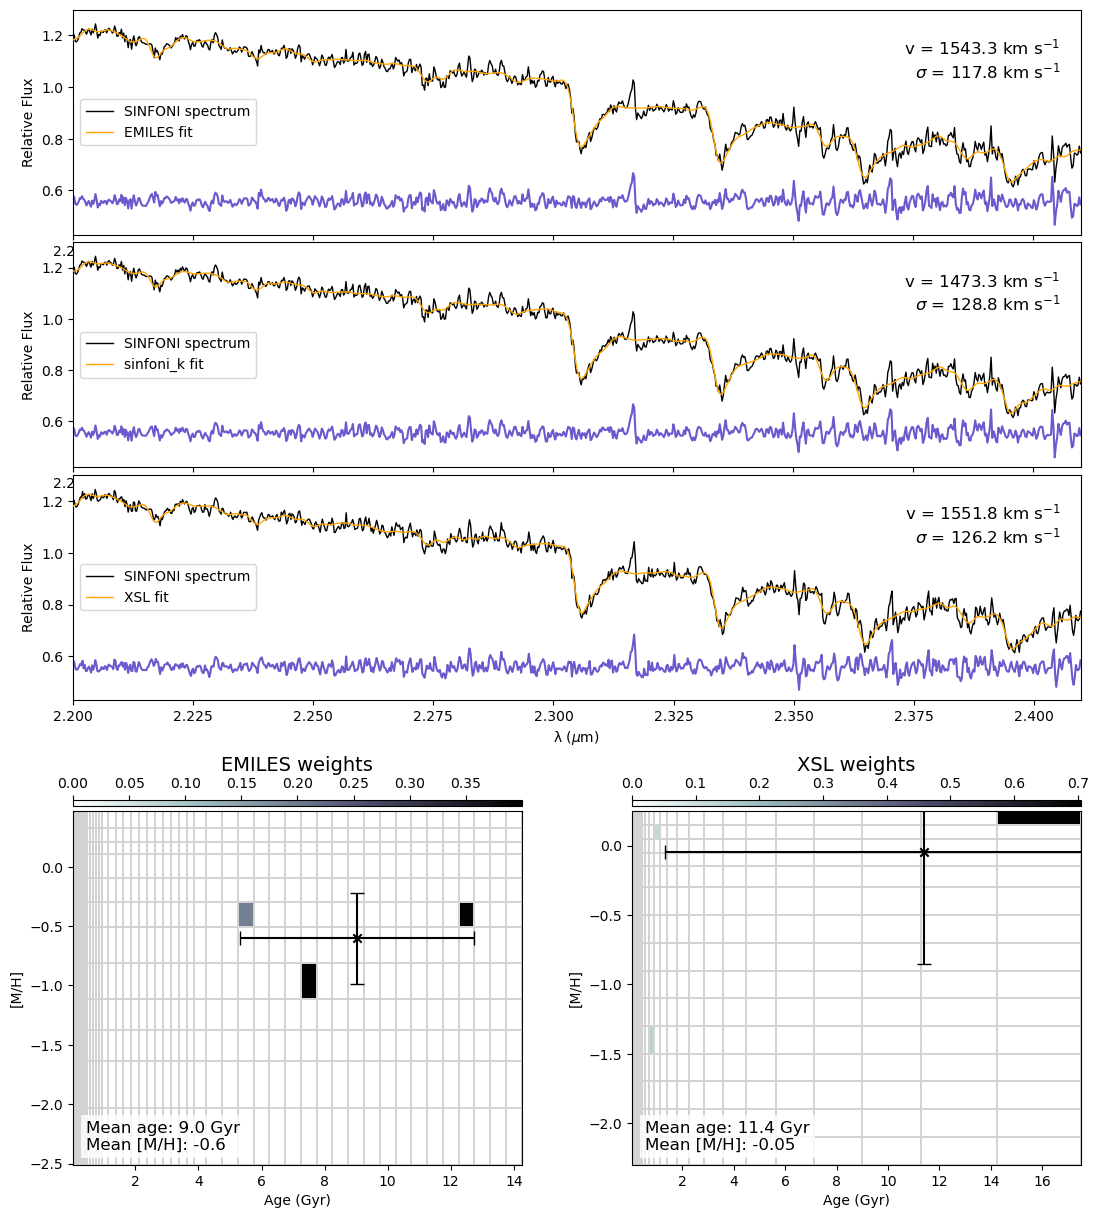

In [10]:


#FCC47 SINFONI plot
fig = plt.figure(figsize=[13, 15])
gs = GridSpec(25, 20, figure=fig)
ax0 = fig.add_subplot(gs[0:5, :])
ax1 = fig.add_subplot(gs[5:10, :])
ax2 = fig.add_subplot(gs[10:15, :])
ax3 = fig.add_subplot(gs[17::, 0:9])
ax4 = fig.add_subplot(gs[17::, 11::])


#plot_spectrum_with_fit(ppw_sin_e, spec_label='SINFONI spectrum', fit_label='E-MILES', title='FCC47 SINFONI', ax=ax0, xlabel='', 
 #                      legend_loc='center left', text_loc=[0.98, 0.78])
ppw_sin_e.plot_kin_fit(ax=ax0, legend_loc='center left', text_loc=[0.98, 0.78])


ppw_sin_sin.plot_kin_fit(ax=ax1, legend_loc='center left', text_loc=[0.98, 0.78])

ppw_sin_xsl.plot_kin_fit(ax=ax2, legend_loc='center left', text_loc=[0.98, 0.78])
ppw.plot_
plot_age_metal_grid(ppw_sin_e,  ax=ax3, )
plot_age_metal_grid(ppw_sin_xsl, ax=ax4, )

#plt.savefig('FCC47_SINFONI_fit.pdf')



In [14]:
spec_sin = ascii.read('../pPXF_wrapper/pPXF_wrapper/spectra/NGC300_sinfoni_spec.dat')

pp_sin_e_n300, templates_sin_e_n300 = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, lam_range=[2.2, 2.41], 
                                                                   instrument='SINFONI', ssp_models = 'EMILES', kin_only=True, vel=130,
                                                                   plot=False                                                                    )


pp_sin_xsl_n300, templates_sin_xsl_n300 = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, 
                                                                       lam_range=[2.2, 2.41], instrument='SINFONI', ssp_models = 'XSL',
                                                                       kin_only=True, vel=130,  plot=False)

pp_sin_sin_n300, templates_sin_sin_n300 = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(spec_sin['wave'], spec_sin['spec'], mask_file=None, 
                                                                       lam_range=[2.2, 2.41], instrument='SINFONI', ssp_models = 'sinfoni_k',
                                                                       kin_only=True, vel=130,  plot=False)



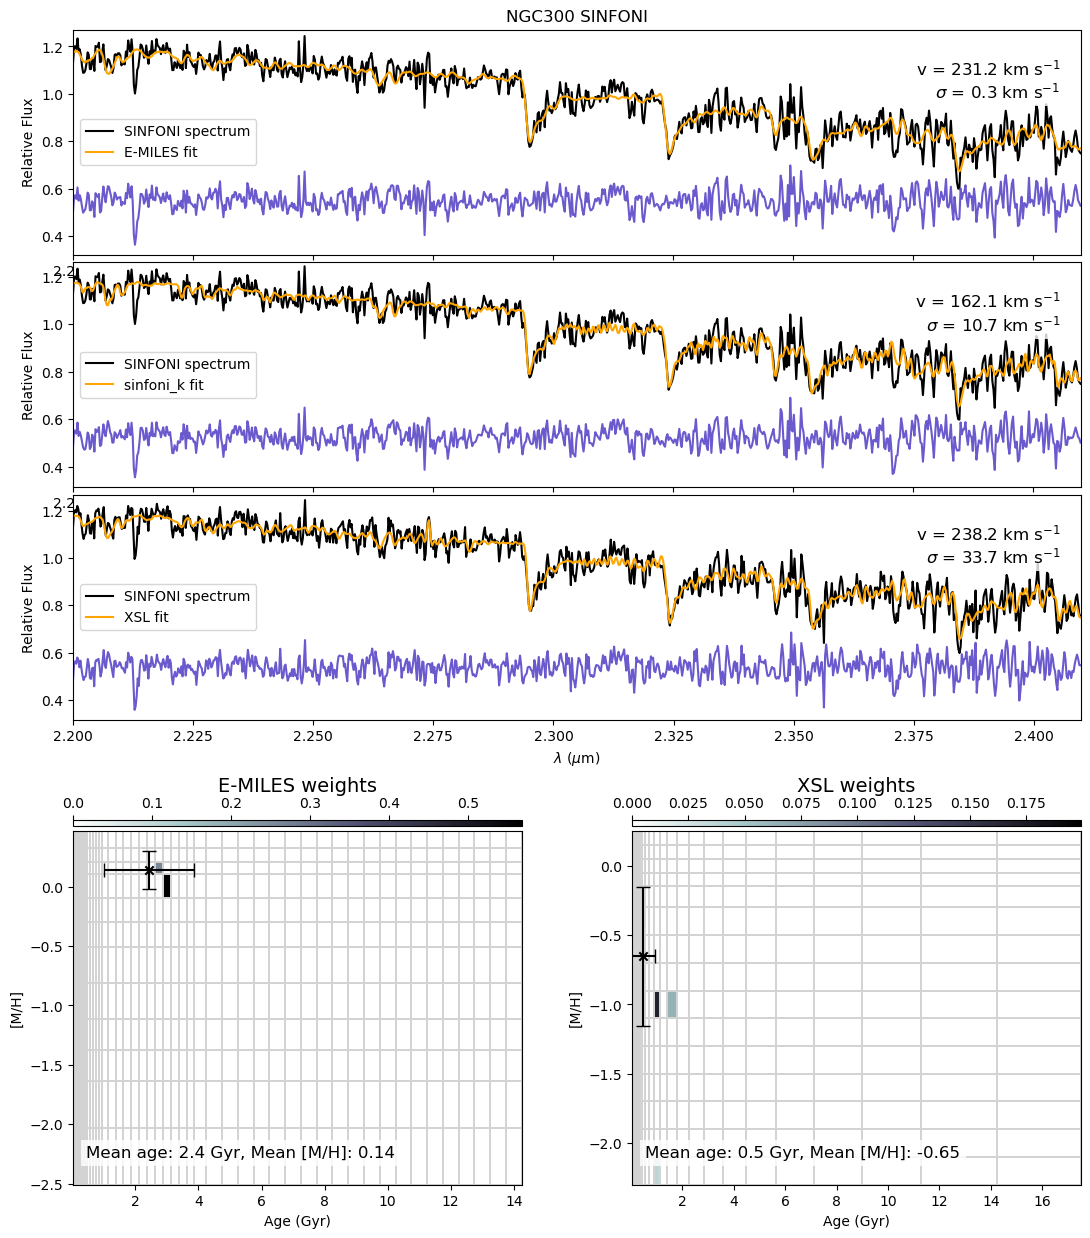

In [15]:
#FCC47 MUSE plot
fig = plt.figure(figsize=[13, 15])
gs = GridSpec(25, 20, figure=fig)
ax0 = fig.add_subplot(gs[0:5, :])
ax1 = fig.add_subplot(gs[5:10, :])
ax2 = fig.add_subplot(gs[10:15, :])
ax3 = fig.add_subplot(gs[17::, 0:9])
ax4 = fig.add_subplot(gs[17::, 11::])


plot_spectrum_with_fit(pp_sin_e_n300, spec_label='SINFONI spectrum', fit_label='E-MILES', title='NGC300 SINFONI', ax=ax0, xlabel='', 
                       legend_loc='center left', text_loc=[0.98, 0.78])
plot_spectrum_with_fit(pp_sin_sin_n300, spec_label='SINFONI spectrum', fit_label='sinfoni_k',  ax=ax1, xlabel='', 
                       legend_loc='center left', text_loc=[0.98, 0.78])
plot_spectrum_with_fit(pp_sin_xsl_n300, spec_label='SINFONI spectrum', fit_label='XSL', title=None, ax=ax2, legend_loc='center left', 
                       text_loc=[0.98, 0.78],
                       xlabel=r'$\lambda$ ($\mu$m)')
plot_age_metal_grid(pp_sin_e_n300, templates_sin_e_n300, ax=ax3, label='E-MILES')
plot_age_metal_grid(pp_sin_xsl_n300, templates_sin_xsl_n300, ax=ax4, label='XSL')

plt.savefig('NGC300_SINFONI_fit.pdf')


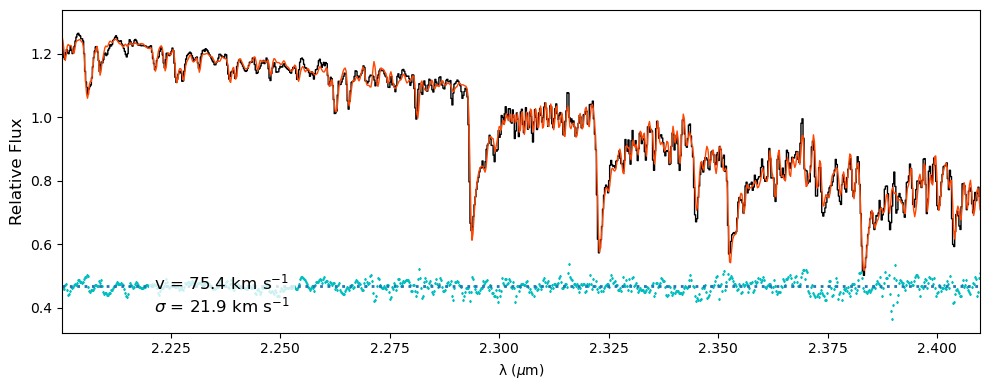

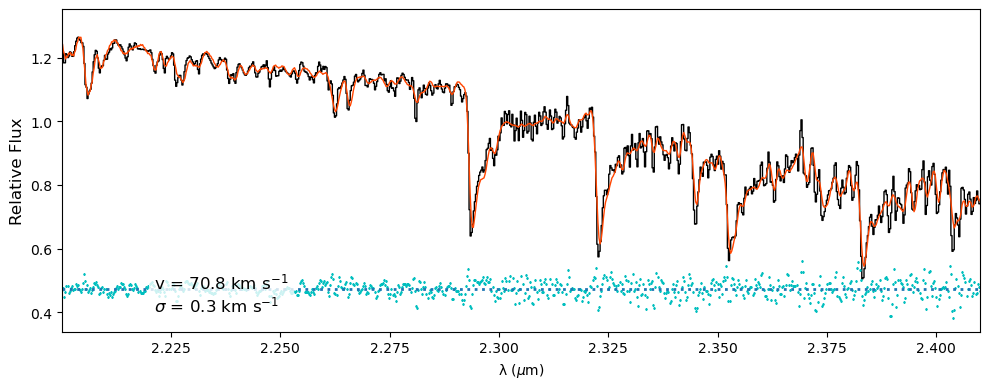

In [19]:
file = '/Users/katja.fahrion/Documents/Scripts/NGC300/SINFONI/ppxf_fitting/sinfoni_k/dtemp3.fits'

hdu = fits.open(file)
spec = hdu[0].data
h2 = hdu[0].header
lam_range_temp = (h2['CRVAL1'] + np.array([0, h2['CDELT1']*(h2['NAXIS1']-1)]))
#print(lam_range_temp)

wave = np.linspace(lam_range_temp[0], lam_range_temp[-1], len(spec))


pp, templates = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(wave, spec, mask_file=None, lam_range=[2.2, 2.41], instrument='SINFONI',
                                       ssp_models = 'XSL', kin_only=True, save_plots=True, vel=130)


pp, templates = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(wave, spec, mask_file=None, lam_range=[2.2, 2.41], instrument='SINFONI',
                                       ssp_models = 'EMILES', kin_only=True, save_plots=True, vel=130)

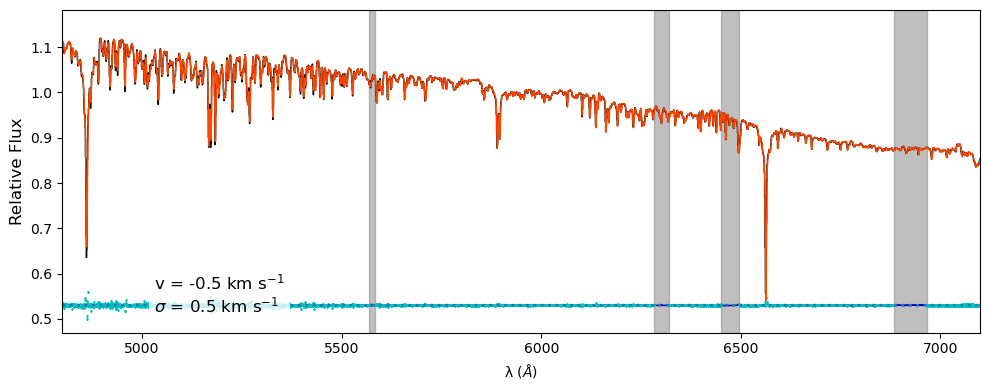

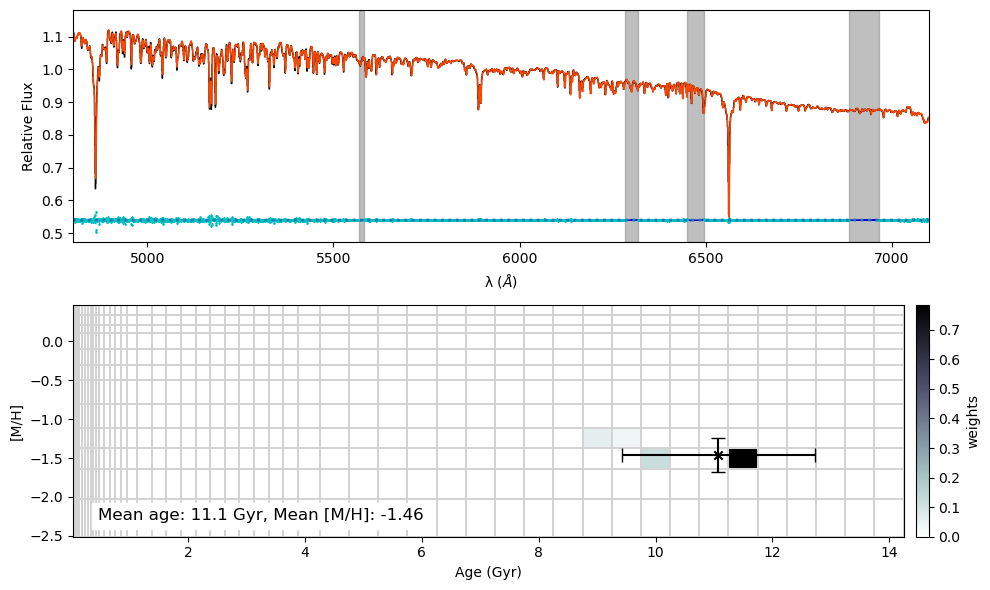

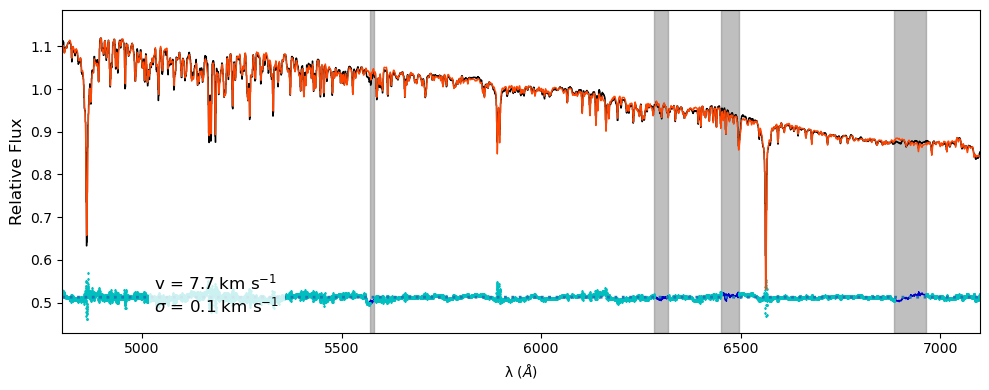

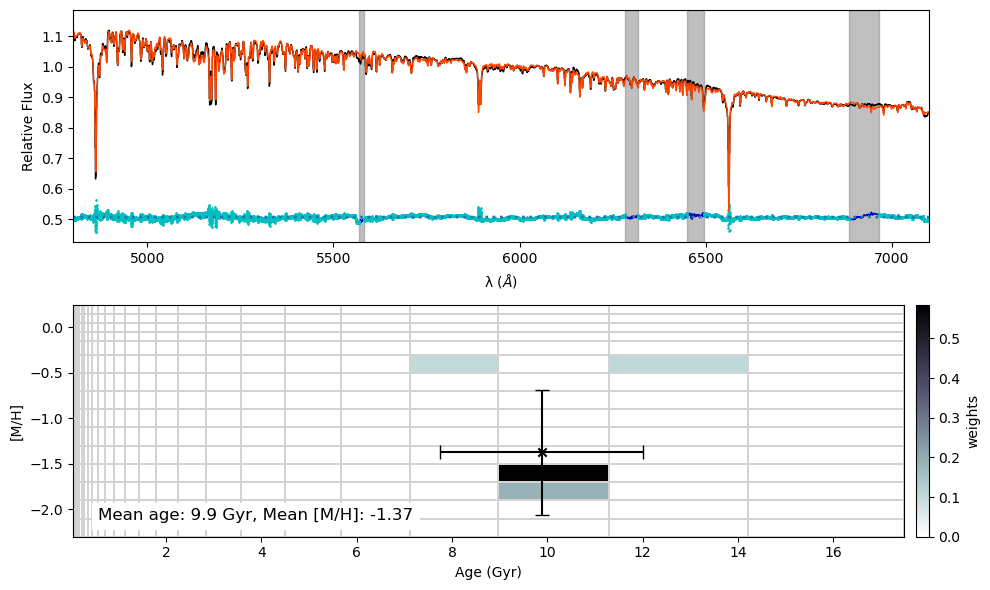

In [23]:
file = '/Users/katja.fahrion/Documents/Scripts/MyPackages/pPXF_wrapper/pPXF_wrapper/templates/EMILES_Basti/Ebi1.30Zm1.49T11.5000_iTp0.00_baseFe.fits'

hdu = fits.open(file)
spec = hdu[0].data
h2 = hdu[0].header
lam_range_temp = (h2['CRVAL1'] + np.array([0, h2['CDELT1']*(h2['NAXIS1']-1)]))
#print(lam_range_temp)

wave = np.linspace(lam_range_temp[0], lam_range_temp[-1], len(spec))

pp, templates = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(wave, spec, mask_file=None, lam_range=[4800, 7100], instrument='MUSE',
                                       ssp_models = 'EMILES', kin_only=False, save_plots=True, vel=130)

pp, templates = pPXF_wrapper.ppxf_wrapper.ppxf_wrapper(wave, spec, mask_file=None, lam_range=[4800, 7100], instrument='MUSE',
                                       ssp_models = 'XSL', kin_only=False, save_plots=True, vel=130)


